# Temporal Naive Bayes (TNB): Validação em Cenário Realista

## Objetivo  
Testar o TNB em condições mais desafiadoras:  
- Parâmetros estimados a partir dos dados.  
- Sobreposição entre classes ($\mu_0 = 0.0$, $\mu_1 = 1.0$).  
- Ruído não-Gaussiano (Laplace).  

## Passos  
1. Geração de dados com sobreposição e ruído não-Gaussiano.  
2. Estimação de $\alpha$, $\mu$, e $\sigma$ via MLE.  
3. Comparação de desempenho: TNB vs. Naive Bayes clássico.  


## Geração de Dados Sintéticos

### Modelo Autoregressivo (AR(1))
Para simular séries temporais com dependência temporal:  
$$x^{(t)} = \mu + \alpha x^{(t-1)} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$


**Parâmetros**:  
- `T = 50`: Comprimento das séries  
- `N_train = 200`, `N_test = 100`: Amostras por classe  
- Classes diferenciadas por médias (\(\mu_0 = 0.0\), \(\mu_1 = 2.0\))  

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import laplace
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm

# Configurações iniciais
np.random.seed(42)
T = 50            # Comprimento de cada série temporal
N_train = 200     # Número de séries por classe para treinamento
N_test = 100      # Número de séries por classe para teste

# Geração de dados sintéticos

In [40]:
# Parâmetros verdadeiros para geração dos dados
alpha_true = 0.8
mu0_true, sigma0_true = 0.0, 1.5  # Classe 0
mu1_true, sigma1_true = 1.0, 1.5  # Classe 1

def generate_sequence(mu, sigma, alpha, T):
    """Gera uma sequência temporal com dependência AR(1) e ruído Laplace."""
    x = np.zeros(T)
    for t in range(1, T):
        mean_t = mu + alpha * x[t-1]
        x[t] = mean_t + np.random.laplace(0, sigma/np.sqrt(2))
    return x

def generate_dataset(mu, sigma, alpha, T, N):
    """Gera um conjunto de N sequências temporais."""
    return np.array([generate_sequence(mu, sigma, alpha, T) for _ in range(N)])

# Gerar conjuntos de treino e teste
X_train0 = generate_dataset(mu0_true, sigma0_true, alpha_true, T, N_train)
X_train1 = generate_dataset(mu1_true, sigma1_true, alpha_true, T, N_train)
X_test0 = generate_dataset(mu0_true, sigma0_true, alpha_true, T, N_test)
X_test1 = generate_dataset(mu1_true, sigma1_true, alpha_true, T, N_test)

X_train = np.concatenate([X_train0, X_train1])
y_train = np.concatenate([np.zeros(N_train), np.ones(N_train)])
X_test = np.concatenate([X_test0, X_test1])
y_test = np.concatenate([np.zeros(N_test), np.ones(N_test)])

# Estimação de Parâmetros

In [43]:
def estimate_alpha(X, mu):
    """Estimativa do coeficiente de autocorrelação."""
    numerator = np.sum((X[:, 1:] - mu) * X[:, :-1])
    denominator = np.sum((X[:, :-1] - mu) ** 2)
    return numerator / denominator

def estimate_mu(X):
    """Estimativa da média dos dados, ignorando o instante inicial."""
    return np.mean(X[:, 1:])

def estimate_sigma(X, mu, alpha):
    """Estimativa do desvio padrão dos resíduos."""
    residuals = X[:, 1:] - (mu + alpha * X[:, :-1])
    return np.std(residuals)

# Estimação iterativa dos parâmetros
def estimate_parameters(X, n_iter=5):
    """Estimativa iterativa de mu, sigma e alpha."""
    mu = np.mean(X[:, 1:])  # Estimativa inicial de mu
    alpha = 0.0  # Inicialização
    
    # Iteração para estimar mu e alpha
    for _ in range(n_iter):
        alpha = np.sum((X[:, 1:] - mu) * X[:, :-1]) / np.sum((X[:, :-1] - mu) ** 2)
        mu = np.mean(X[:, 1:] - alpha * X[:, :-1])
    
    # Estimativa de sigma
    residuals = X[:, 1:] - (mu + alpha * X[:, :-1])
    sigma = np.sqrt(np.mean(residuals**2))  # RMS para Laplace
    
    return mu, sigma, alpha

# Estimar parâmetros para ambas as classes
mu0_hat, sigma0_hat, alpha0_hat = estimate_parameters(X_train0)
mu1_hat, sigma1_hat, alpha1_hat = estimate_parameters(X_train1)

print(f"Parâmetros estimados - Classe 0: mu={mu0_hat:.2f}, sigma={sigma0_hat:.2f}, alpha={alpha0_hat:.2f}")
print(f"Parâmetros estimados - Classe 1: mu={mu1_hat:.2f}, sigma={sigma1_hat:.2f}, alpha={alpha1_hat:.2f}")

Parâmetros estimados - Classe 0: mu=-0.03, sigma=1.48, alpha=0.79
Parâmetros estimados - Classe 1: mu=0.38, sigma=1.56, alpha=0.94


## Implementação do Temporal Naive Bayes

A modificação no Naive Bayes para incorporar a dependência temporal.
A equação utilizada para o TNB é:  

$$P(C_k | X^{(t)}) \propto P(C_k) \prod_{t=1}^{T} P(x^{(t)} | C_k,x^{(t-1)})$$

Utilizou-se a função `norm.logpdf` para calcular o log da densidade de probabilidade da distribuição normal com média $\mu + \alpha \cdot x^{t-1}$ e variância $\sigma^2$


In [44]:
def log_likelihood_TNB(x, mu, sigma, alpha):
    """Log-verossimilhança para o modelo TNB com ruído Laplace."""
    ll = 0.0
    for t in range(1, len(x)):
        mean_t = mu + alpha * x[t-1]
        ll += laplace.logpdf(x[t], loc=mean_t, scale=sigma/np.sqrt(2))
    return ll

def classify_sequence(seq, params0, params1):
    """Classifica uma sequência usando os parâmetros estimados."""
    mu0, sigma0, alpha0 = params0
    mu1, sigma1, alpha1 = params1
    ll0 = log_likelihood_TNB(seq, mu0, sigma0, alpha0)
    ll1 = log_likelihood_TNB(seq, mu1, sigma1, alpha1)
    return 0 if ll0 > ll1 else 1

# Avaliação do Modelo
Cálculo de Acurácia, Matriz de Confusão e Relatório de Classificação

Acurácia: 0.990

Matriz de Confusão:
[[ 98   2]
 [  0 100]]

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       1.00      0.98      0.99       100
    Classe 1       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



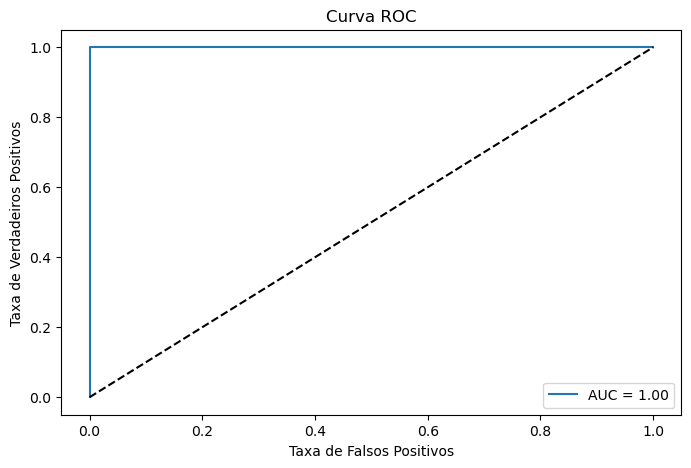

In [45]:
params0 = (mu0_hat, sigma0_hat, alpha0_hat)
params1 = (mu1_hat, sigma1_hat, alpha1_hat)

# Classificação do conjunto de teste
y_pred = np.array([classify_sequence(x, params0, params1) for x in X_test])

# Métricas de desempenho
print(f"Acurácia: {accuracy_score(y_test, y_pred):.3f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"]))

# Curva ROC
scores = np.array([log_likelihood_TNB(x, *params1) - log_likelihood_TNB(x, *params0) for x in X_test])
fpr, tpr, _ = roc_curve(y_test, scores)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Comparação com o Naive Bayes Clássico (Baseline)

Nesta etapa, implementamos o Naive Bayes clássico que trata cada instância temporal de forma independente, ou seja, sem incorporar a dependência do valor anterior.
A fórmula de verossimilhança usada é:

$$P(C_k | X) \propto P(C_k) \cdot \prod_{i=1}^{n} P(x_i | C_k)$$

Em seguida, comparamos a acurácia do modelo clássico com a do TNB. No seu exemplo, o TNB apresentou 99,0% de acurácia enquanto o modelo clássico alcançou cerca de 70,0%, indicando a vantagem de incorporar a dependência temporal.

In [46]:
def log_likelihood_classic(x, mu, sigma):
    """Log-verossimilhança para modelo clássico com ruído Laplace."""
    return np.sum(laplace.logpdf(x[1:], loc=mu, scale=sigma/np.sqrt(2)))

def classic_classifier(x, params0, params1):
    mu0, sigma0, _ = params0
    mu1, sigma1, _ = params1
    ll0 = log_likelihood_classic(x, mu0, sigma0)
    ll1 = log_likelihood_classic(x, mu1, sigma1)
    return 0 if ll0 > ll1 else 1

y_pred_classic = np.array([classic_classifier(x, params0, params1) for x in X_test])
print(f"\nAcurácia do Naive Bayes Clássico: {accuracy_score(y_test, y_pred_classic):.3f}")


Acurácia do Naive Bayes Clássico: 0.700
